In [ ]:
# Analysis of Disulfide Bonds in Proteins of Known Structure 
# Author: Eric G. Suchanek, PhD.
# Last revision: 1/19/23 -egs-
# Cα Cβ Sγ


import math
import time
import gc

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import plotly_express as px
import seaborn as sns

import proteusPy
from proteusPy import *
from proteusPy.Disulfide import *

from proteusPy.ProteusGlobals import *

import pandas as pd
import pyvista as pv
from pyvista import set_plot_theme

import psutil

plt.style.use('seaborn-v0_8-notebook')
#print(f'{plt.style.available}')

# ipyvtklink
pv.set_jupyter_backend('ipyvtklink')

set_plot_theme('document')

# the locations below represent the actual location on the dev drive.
# location for PDB repository
PDB_BASE = '/Users/egs/PDB/'

# location of cleaned PDB files
PDB = '/Users/egs/PDB/good/'

# location of the compressed Disulfide .pkl files
MODELS = f'{PDB_BASE}models/'

# when running from the repo the local copy of the Disulfides is in proteusPy/data
# the locations below represent the actual location on the dev drive.
# location for PDB repository
# takes 
PDB_BASE = '/Users/egs/PDB/'

# location of the compressed Disulfide .pkl files. Currently I don't have the entire
# dataset in the repo, so to load the full dataset I point to my dev drive

DATA = f'{PDB_BASE}data/'

# Set the figure sizes and axis limits.
DPI = 220
WIDTH = 6.0
HEIGHT = 3.0
TORMIN = -179.0
TORMAX = 180.0
GRIDSIZE = 20

elapsed = 0

# some useful f-strings
MEM_USAGE = f'Memory used: {psutil.Process().memory_info().rss / (1024 * 1024)} MB'
ELAPSED_TIME = f'Complete. Elapsed time: {datetime.timedelta(seconds=elapsed)} (h:m:s)'


In [ ]:
# Load the dataset
PDB_SS = DisulfideLoader(verbose=True, subset=True, datadir=DATA)


In [ ]:
#
# retrieve the torsions dataframe
from proteusPy.Disulfide import Torsion_DF_Cols

_SSdf = PDB_SS.getTorsions()
# there are a few structures with bad SSBonds. Their
# CA distances are > 7.0. We remove them from consideration
# below

#_far = _SSdf['ca_distance'] >= 9.0

_near = _SSdf['ca_distance'] < 9.0
_left = _SSdf['chi3'] < 0.0
_right = _SSdf['chi3'] > 0.0

# entire database
SS_df = _SSdf[_near]

# split by chi3
SS_df_left = _SSdf[_left]
SS_df_right = _SSdf[_right]

SS_df = SS_df[Torsion_DF_Cols].copy()
SS_df.describe()

print(f'Memory used: {psutil.Process().memory_info().rss / (1024 * 1024)} MB')

del _near
del _left
del _right

print(f'Memory used: {psutil.Process().memory_info().rss / (1024 * 1024)} MB')


In [82]:
print(f'{plt.style.available}')


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


Spectral Clustering starts
Complete. Elapsed time: 0:00:00.700789 (h:m:s)


<AxesSubplot: title={'center': 'Spectral Clustering'}, xlabel='ca_distance', ylabel='torsion_length'>

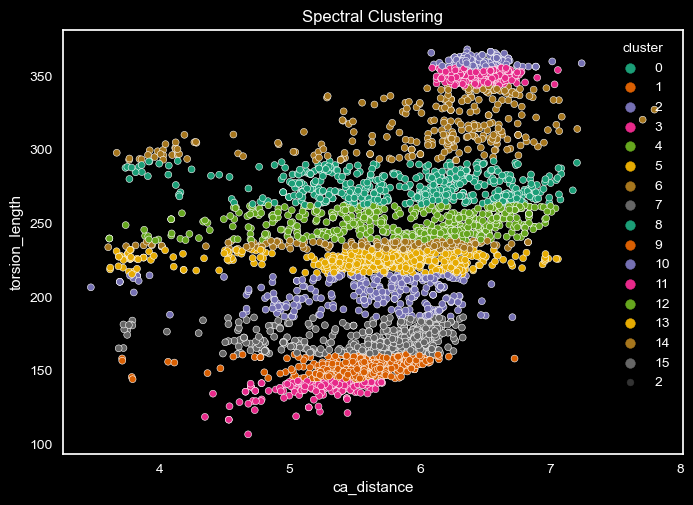

In [95]:

# 2
# takes over an hour for full dataset
from sklearn.cluster import SpectralClustering

#print(f'{plt.style.available}')

#plt.style.use('seaborn-v0_8-bright')
plt.style.use('dark_background')


_cols = ['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'torsion_length', 'energy', 'ca_distance']

start = time.time()

ss = SS_df_left[_cols].copy()
X = ss.copy()

n_clusters = 16
custom_palette = sns.color_palette("Dark2", n_clusters)

scm_model = SpectralClustering(n_clusters=n_clusters, random_state=25,
                                n_neighbors=32, affinity='nearest_neighbors')
# takes 51 min with full dataset

print(f'Spectral Clustering starts')
X['cluster'] = scm_model.fit_predict(X[['torsion_length']])
end = time.time()

elapsed = end - start

print(f'Complete. Elapsed time: {datetime.timedelta(seconds=elapsed)} (h:m:s)')

fig, ax = plt.subplots()
ax.set(title='Spectral Clustering')
sns.scatterplot(x='ca_distance', y='torsion_length', data=X, hue='cluster', ax=ax, size=2, palette=custom_palette)


In [96]:
#
# takes over an hour for full dataset
from sklearn.cluster import AffinityPropagation

start = time.time()

n_clusters = 4
_cols = ['chi1', 'chi2', 'chi4', 'chi5', 'torsion_length', 'chi3']

tor_df = SS_df[_cols].copy()
X = tor_df.copy()

aff_model = AffinityPropagation(max_iter=800, random_state=25)

# takes 51 min with full dataset
X['cluster'] = aff_model.fit_predict(X[['torsion_length']])
end = time.time()

elapsed = end - start

print(f'Complete. Elapsed time: {datetime.timedelta(seconds=elapsed)} (h:m:s)')



/Users/egs/miniforge3/envs/proteus/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Complete. Elapsed time: 0:04:21.344703 (h:m:s)


In [ ]:
n_clusters = 16
custom_palette = sns.color_palette("Dark2", n_clusters)

fig, ax = plt.subplots()
ax.set(title='Affinity Propagation')

sns.scatterplot(x='chi1', y='torsion_length', data=X, hue='cluster', ax=ax, size=1, palette=custom_palette)


In [ ]:
print(f'{MEM_USAGE}')

In [ ]:

from sklearn.mixture import GaussianMixture

start = time.time()

n_clusters = 16

_cols = ['chi1', 'chi2', 'chi4', 'chi5', 'torsion_length', 'chi3', 'ca_distance']

tor_df = SS_df[_cols].copy()
tor_df.head(1)
gmm_model = GaussianMixture(n_components=n_clusters)
gmm_model.fit(tor_df)
cluster_labels = gmm_model.predict(tor_df)
X = pd.DataFrame(tor_df)
X['cluster'] = cluster_labels
for k in range(n_clusters):
    data = X[X['cluster'] == k]
    plt.scatter(data['torsion_length'], data['ca_distance'], s=1)

plt.show()


end = time.time()
elapsed = end - start

print(f'Complete. Elapsed time: {datetime.timedelta(seconds=elapsed)} (h:m:s)')

In [ ]:
# takes over an hour for full dataset
from sklearn.cluster import AgglomerativeClustering
n_clusters = 4

_cols = ['chi1', 'chi2', 'chi4', 'chi5', 'torsion_length', 'chi3', 'ca_distance']
tor_df = SS_df[_cols].copy()

X = tor_df.copy()

agg_model = AgglomerativeClustering(n_clusters=n_clusters)

X['cluster'] = agg_model.fit_predict(X[['torsion_length', 'ca_distance']])

fig, ax = plt.subplots()
ax.set(title='Agglomerative Clustering')
sns.scatterplot(x='chi2', y='chi4', data=X, hue='cluster', ax=ax, size=2)
